## Florida Department of Corrections Inmate Crime and Tattoo Database
#### Joey, Matt, Sean

### 1, 2. The Dataset, Downloaded

In [1]:
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas
import pandas_access
%matplotlib inline
DATASET = "./FDOC_January_2017.mdb" # From http://www.dc.state.fl.us/pub/obis_request.html 
                                    # ~1.3 gb; publicly available data.

### 3. Loading into a DF

In [2]:
dfs = {}
for tablename in pandas_access.list_tables(DATASET):
    dfs[tablename] = pandas_access.read_table(DATASET, tablename, low_memory = False)

### 4. Identifying Variables of Interest

In [3]:
dfs.keys()

[u'INMATE_RELEASE_INCARHIST',
 u'INMATE_ACTIVE_ROOT',
 u'INMATE_RELEASE_DETAINERS',
 u'OFFENDER_OFFENSES_CCS',
 u'INMATE_RELEASE_OFFENSES_CPS',
 u'INMATE_RELEASE_RESIDENCE',
 u'INMATE_RELEASE_SCARSMARKS',
 u'INMATE_ACTIVE_ALIASES',
 u'INMATE_ACTIVE_DETAINERS',
 u'INMATE_RELEASE_OFFENSES_prpr',
 u'INMATE_ACTIVE_SCARSMARKS',
 u'OFFENDER_ROOT',
 u'OFFENDER_RESIDENCE',
 u'INMATE_ACTIVE_OFFENSES_prpr',
 u'OFFENDER_ALIASES',
 u'INMATE_RELEASE_ROOT',
 u'INMATE_ACTIVE_INCARHIST',
 u'INMATE_ACTIVE_OFFENSES_CPS',
 u'CONTENTS',
 u'INMATE_RELEASE_ALIASES']

We initially planned to duplicate the experiment that linked tattoos and crimes, so we'll look at `SCARSMARKS` and `OFFENSES`.

### 5. Validation and Plotting

In [4]:
# http://www.dc.state.fl.us/pub/obis_request.html
# http://cdn.static-economist.com/sites/default/files/images/print-edition/20161224_XMC337_0.png

First, let's look at the number and types of tattoos:

In [5]:
tattoos = pandas.concat((dfs["INMATE_ACTIVE_SCARSMARKS"], dfs["INMATE_RELEASE_SCARSMARKS"]))
tattoo_descriptions = tattoos.Description
len(tattoo_descriptions)

1266840

In [6]:
tattoo_types = {
    "face": ["FACE", "HEAD", "CHEEK", "CHIN"],
    "white supremacist": ["WHITE", "ARYAN", "NAZI", "SWASTIKA", "14", "88"],
    "three dots": ["3 DOTS", "THREE DOTS", "3DOTS", "THREEDOTS", "TRIANGLE DOTS", "DOT TRIANGLE"],
    "tear drop": ["TEAR DROP", "TEARDROP"],
    "guns": ["GUN", "RIFLE", "BULLET"],
    "laugh now, cry later": ["LAUGH NOW", "CRY LATER", "LAUGHNOW", "CRYLATER"],
    "christian": ["CROSS", "HOLY", "ANGEL", "JESUS", "PRAY"],
    "satanic": ["PENTA", "DEVIL", "DEMON", "BAPHOMET"],
    "none": ["nan", "NaN"]
}
for category, keywords in tattoo_types.items():
    counts = tattoo_descriptions.str.contains("|".join(keywords)).value_counts()
    count = counts[True] if True in counts else 0
    print("{0: <20} {1: >7}".format(category, count))

none                       0
christian             138926
three dots              2886
satanic                18522
tear drop               7946
laugh now, cry later    4397
guns                   21472
white supremacist       6745
face                   71814


Next, let's look at the number and types of crimes:

In [7]:
crimes = pandas.concat((dfs["INMATE_ACTIVE_OFFENSES_prpr"], dfs["INMATE_ACTIVE_OFFENSES_CPS"], dfs["INMATE_RELEASE_OFFENSES_prpr"], dfs["INMATE_RELEASE_OFFENSES_CPS"]))
crime_descriptions = crimes.adjudicationcharge_descr
len(crime_descriptions)

2385493

In [8]:
crime_types = {
    "drugs": ["DRUG", "COCAINE", "SUBS", "MARIJUANA"],
    "theft": ["BURG", "THEFT", "THFT"],
    "robbery": ["ROBB"],
    "assault": ["ASLT", "ASSLT", "ASSAULT", "BATT"],
    "murder": ["MUR", "MRDR"]
}
for category, keywords in crime_types.items():
    counts = crime_descriptions.str.contains("|".join(keywords)).value_counts()
    count = counts[True] if True in counts else 0
    print("{0: <7} {1: >6}".format(category, count))

drugs   427856
assault 206298
murder   33311
robbery 140578
theft   720649


Now, let's group them together and use the totals in each category to calculate a ratio:

In [9]:
tattoos_crimes = pandas.merge(tattoos, crimes, "outer", "DCNumber")
tattoos_crimes.rename(index = str, columns = {
        "Description": "tattoos",
        "adjudicationcharge_descr": "crimes"
    }, inplace = True)

In [10]:
grouped_tattoos = tattoos_crimes.tattoos.groupby(tattoos_crimes.DCNumber).apply(lambda x: ",".join(set(x.astype(str))))
grouped_crimes = tattoos_crimes.crimes.groupby(tattoos_crimes.DCNumber).apply(lambda x: ",".join(set(x.astype(str))))
tattoos_and_crimes = pandas.concat([grouped_tattoos, grouped_crimes], axis = 1).reset_index()

In [11]:
tattoo_totals = {}
for tattoo, tattoowords in tattoo_types.items():
    tattoo_totals[tattoo] = tattoo_totals.get(tattoo, 0) + \
                            len(tattoos_and_crimes[tattoos_and_crimes.tattoos.str.contains("|".join(tattoowords))])
tattoo_totals

{'christian': 98267,
 'face': 51337,
 'guns': 17048,
 'laugh now, cry later': 3860,
 'none': 149392,
 'satanic': 14919,
 'tear drop': 7446,
 'three dots': 2646,
 'white supremacist': 5553}

In [12]:
crime_totals = {}
for crime, crimewords in crime_types.items():
    crime_totals[crime] = crime_totals.get(crime, 0) + \
                          len(tattoos_and_crimes[tattoos_and_crimes.crimes.str.contains("|".join(crimewords))])
crime_totals

{'assault': 124886,
 'drugs': 161320,
 'murder': 25788,
 'robbery': 75437,
 'theft': 193781}

In [13]:
avg_crime_rates = {
    k: 100.0 * v / len(tattoos_and_crimes)
    for k, v in crime_totals.items()
}
avg_crime_rates

{'assault': 27.49224561318543,
 'drugs': 35.51278015405308,
 'murder': 5.676937606079351,
 'robbery': 16.606605482775244,
 'theft': 42.65870351495512}

In [14]:
per_tattoo_crime_rates = {}
for tattoo, tattoowords in tattoo_types.items():
    for crime, crimewords in crime_types.items():
        count = len(tattoos_and_crimes[tattoos_and_crimes.tattoos.str.contains("|".join(tattoowords)) &\
                                       tattoos_and_crimes.crimes.str.contains("|".join(crimewords))])
        percent = 100.0 * count / tattoo_totals[tattoo]
        per_tattoo_crime_rates[(tattoo, crime)] = (count, percent)
        print("{0: >6.2f}% of people with {1: <20} tattoos committed {2: <7} crimes ({3: >5} people)".format(percent, tattoo, crime, count))

 34.70% of people with none                 tattoos committed drugs   crimes (51838 people)
 26.34% of people with none                 tattoos committed assault crimes (39352 people)
  6.50% of people with none                 tattoos committed murder  crimes ( 9707 people)
 13.59% of people with none                 tattoos committed robbery crimes (20297 people)
 36.47% of people with none                 tattoos committed theft   crimes (54479 people)
 35.65% of people with christian            tattoos committed drugs   crimes (35032 people)
 28.33% of people with christian            tattoos committed assault crimes (27839 people)
  4.78% of people with christian            tattoos committed murder  crimes ( 4701 people)
 17.75% of people with christian            tattoos committed robbery crimes (17438 people)
 46.81% of people with christian            tattoos committed theft   crimes (46002 people)
 23.85% of people with three dots           tattoos committed drugs   crimes (  

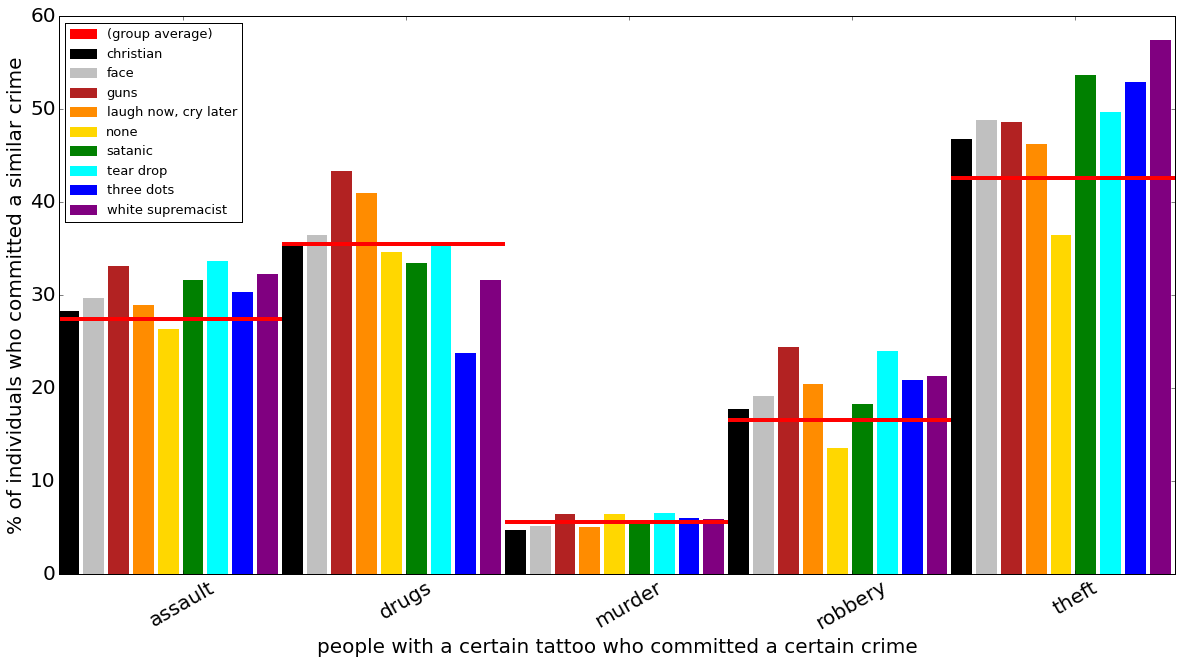

In [15]:
colors = ["black", "silver", "firebrick", "darkorange", "gold", "green", "cyan", "blue", "purple"]
crimes = sorted(crime_types.keys())
tattoos = sorted(tattoo_types.keys())
fig, ax = plt.subplots(figsize = (20, 10))
matplotlib.rc("font", size = 20)

ys = []
for crime in crimes:
    for tattoo in tattoos:
        percent = per_tattoo_crime_rates[(tattoo, crime)][1]
        ys.append(percent)

xs = range(len(crimes) * len(tattoos))
cs = colors[:len(tattoos)] * len(crimes)
positions = [i * len(tattoos) + len(tattoos) / 2 + 1 for i in range(len(crimes))]

bars = plt.bar(xs, ys)
for i, b in enumerate(bars):
    b.set_color(cs[i])

for i in range(len(crimes)):
    avg = avg_crime_rates[crimes[i]]
    start = i * len(tattoos)
    end = start + len(tattoos)
    plt.hlines(avg, start, end, colors = "red", linewidth = 4)

ax.set_xticks(positions)
ax.set_xticklabels(crimes, rotation = 30)
plt.xlabel("people with a certain tattoo who committed a certain crime")
plt.ylabel("% of individuals who committed a similar crime")
artists = [mpatches.Patch(color = colors[i]) for i in range(len(tattoos))]
artists.insert(0, mpatches.Patch(color = "red"))
plt.legend(artists, ["(group average)"] + tattoos, loc = "best", prop = {"size": 13})
plt.show()

And we can further divide this into sub-plots, separated by crime or tattoo:

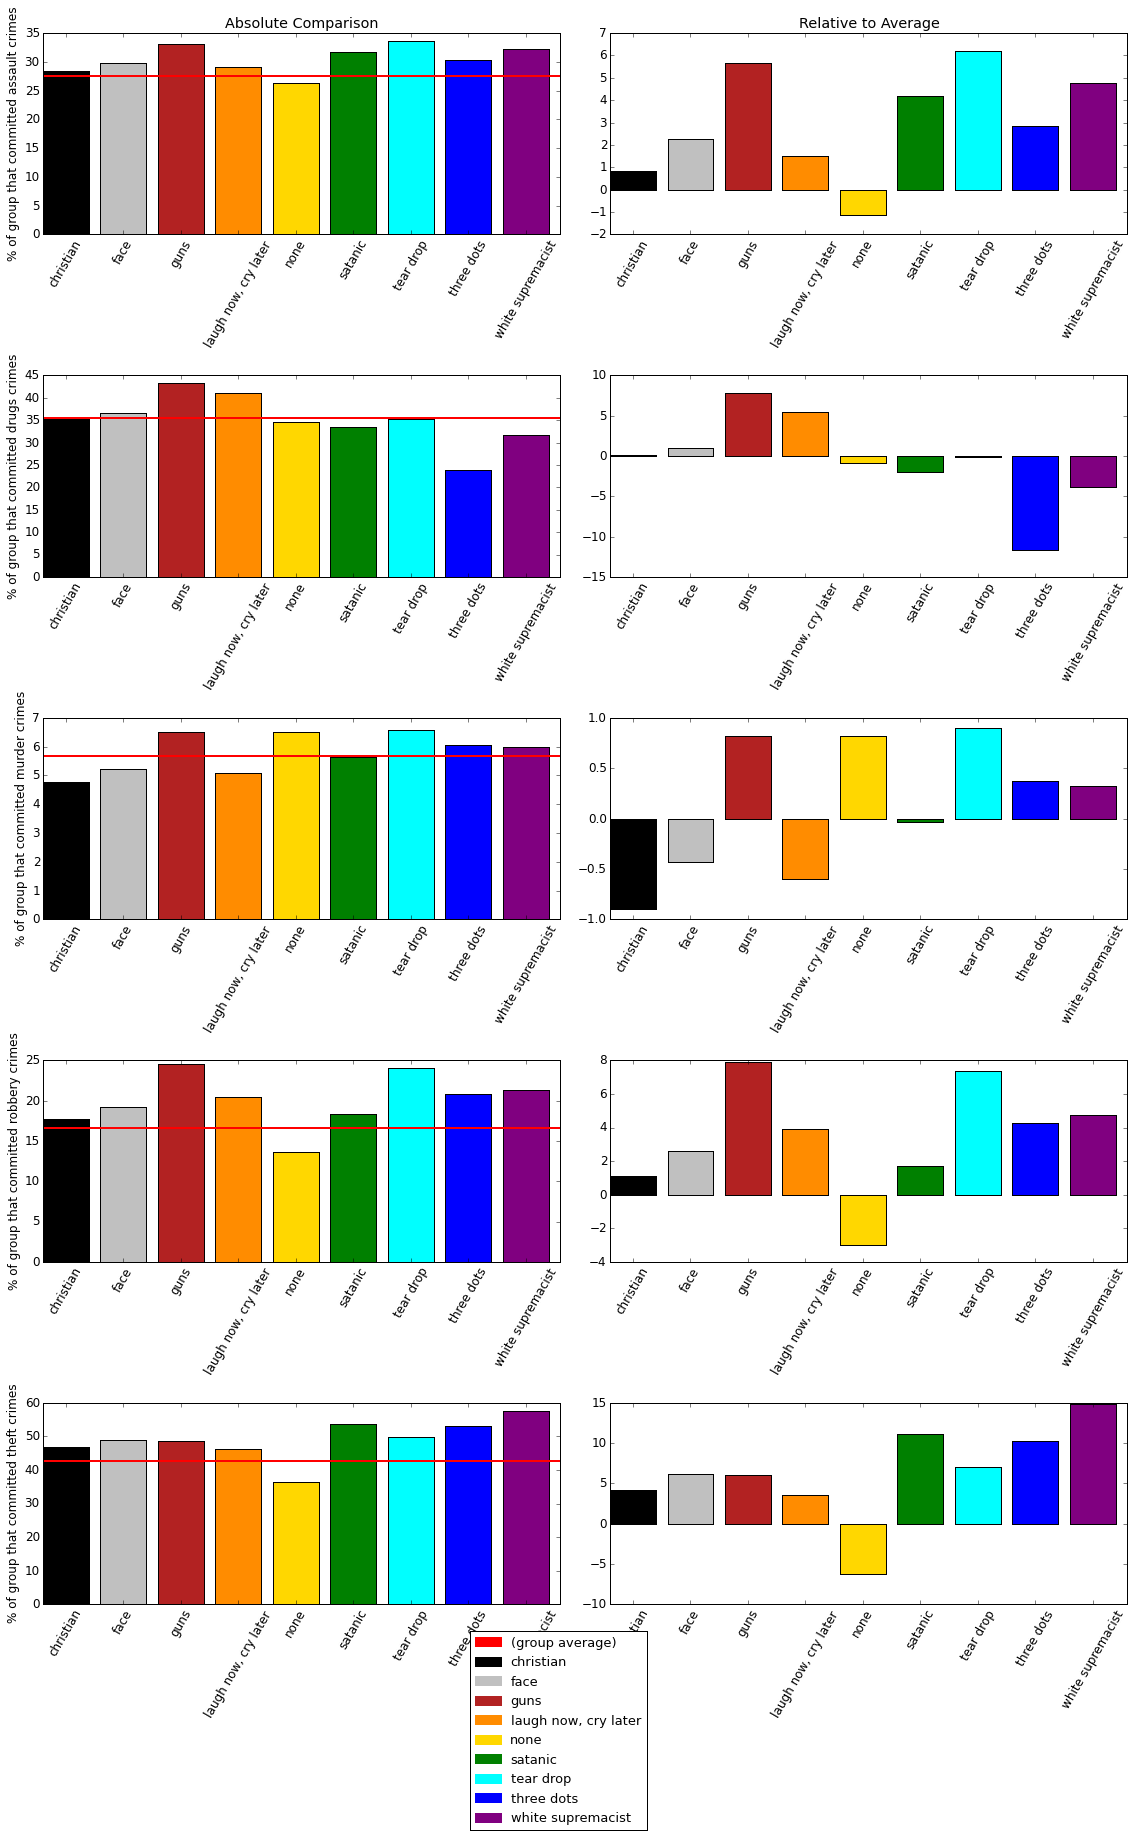

In [16]:
matplotlib.rc("font", size = 12)
fig, axes = plt.subplots(len(crimes), 2, figsize = (16, 24))
for i, axarr in enumerate(axes):
    start = i * len(tattoos)
    end = start + len(tattoos)
    avg = avg_crime_rates[crimes[i]]
    axarr[0].bar(range(start, end), ys[start:end], color = colors)
    axarr[0].hlines(avg, start, end, "red", linewidth = 2)
    axarr[1].bar(range(start, end), [val - avg for val in ys[start:end]], color = colors)
    for ax in axarr:
        ax.set_xticks([j + 0.4 for j in range(start, end)])
        ax.set_xticklabels(tattoos, rotation = 60)
    axarr[0].set_ylabel("% of group that committed {0} crimes".format(crimes[i]))

axes[0][0].set_title("Absolute Comparison")
axes[0][1].set_title("Relative to Average")
plt.legend(artists, ["(group average)"] + tattoos, loc = 9, bbox_to_anchor = (-0.1, -0.1), prop = {"size": 13})
plt.tight_layout()
plt.show()

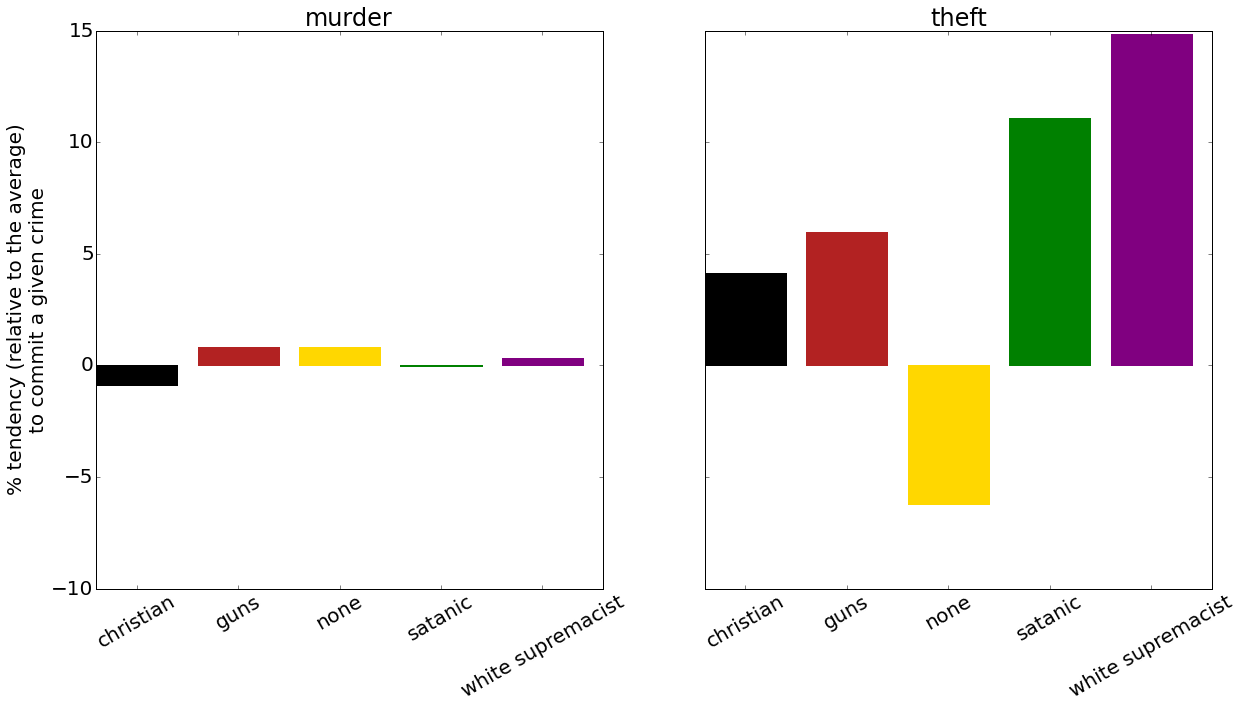

In [17]:
trimmed_colors = ["black", "firebrick", "gold", "green", "purple"]
trimmed_tattoos = ["christian", "guns", "none", "satanic", "white supremacist"]
trimmed_crimes = ["murder", "theft"]
fig, axes = plt.subplots(1, len(trimmed_crimes), figsize = (20, 10), sharey = True)
matplotlib.rc("font", size = 20)

for i in range(len(trimmed_crimes)):
    ax = axes[i]
    xs = range(len(trimmed_tattoos))
    ys = []
    crime = trimmed_crimes[i]
    for tattoo in trimmed_tattoos:
        percent_diff = per_tattoo_crime_rates[(tattoo, crime)][1] - avg_crime_rates[crime]
        ys.append(percent_diff)
    cs = trimmed_colors[:len(trimmed_tattoos)]
    positions = [j + 0.4 for j in range(len(trimmed_tattoos))]

    bars = ax.bar(xs, ys)
    for j, b in enumerate(bars):
        b.set_color(cs[j])

    ax.set_title(crime)
    ax.set_xticks(positions)
    ax.set_xticklabels(trimmed_tattoos, rotation = 30)

axes[0].set_ylabel("% tendency (relative to the average)\nto commit a given crime")
plt.show()

### 6. Cleaning Issues

For validation, it's hard to know what the baseline that The Economist used was; are their relationships based on the typical crimes for someone with certain tattoos, or the typical tattoos had by someone who commits certain crimes, or something else entirely?